In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install -q tensorflow==2.6.4
!pip3 install -q keras==2.6
!pip3 install -U -q segmentation-models

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.3/464.3 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 89.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 

In [3]:
import glob
import skimage.io as ski
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import jaccard_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
scaler = MinMaxScaler()
import cv2
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [4]:
def crop(img, h, w):
    """Crops the image until to match with specified height and width values

    Args:
        img (ndarray): image name
        h (int): wanted number of pixels for height
        w (int): wanted number of pixels for width

    Returns:
        img (ndarray): cropped image
    """
    diff_h = img.shape[0] - h
    diff_w = img.shape[1] - w
    if diff_h > 0:
        if diff_h%2 == 0:        
            img = img[diff_h//2:img.shape[0] - diff_h//2, :]
        else:
            img = img[diff_h//2 + 1:img.shape[0] - diff_h//2, :]
    if diff_w > 0:
        if diff_w%2 == 0:
            img = img[:, diff_w//2:img.shape[1] - diff_w//2]
        else:
            img = img[:, diff_w//2 + 1:img.shape[1] - diff_w//2]
    return img

In [5]:
def resize_padding(image, RGB, h_target, w_target):
    """Adds some padding to an image to match with specified height and width values

    Args:
        image (ndarray): image name
        RGB (boolean): True if RGB (3 channels), False if greyscale
        h_target (int): wanted number of pixels for height
        w_target (int): wanted number of pixels for width
    Returns:
        result (ndarray): padded image
    """
    
    h, w = image.shape[0:2]
    if h_target < h or w_target < w:
        print("Specified dimensions smaller than the input image")
        return None
        
    delta_h = h_target - h
    delta_w = w_target - w

    pad_up = delta_h//2
    pad_down = h_target - h - pad_up
    pad_left = delta_w//2
    pad_right = w_target - w - pad_left
    if RGB:
        result = cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, cv2.BORDER_CONSTANT, value = [255,255,255])
    else:
        result = cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, cv2.BORDER_CONSTANT, value = 0) 
    return(result)

Here an example of a padded image : 


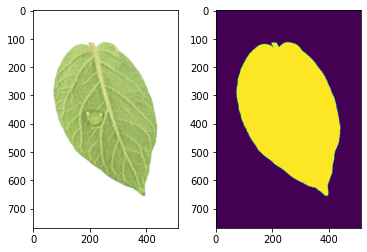

In [6]:
files_vis = ski.imread_collection("/content/drive/MyDrive/Train_leaves/Train_dataset/Vis/*").files
files_gt = ski.imread_collection("/content/drive/MyDrive/Train_leaves/Train_dataset/GT/*").files
vis = [ski.imread(image_path) for image_path in files_vis]
gt = [ski.imread(image_path) for image_path in files_gt]

vis_padded = [resize_padding(im, True, 768, 512) for im in vis]    #we want multiples of 256
gt_padded = [resize_padding(im, False, 768, 512) for im in gt]
vis_padded = np.array(vis_padded)
gt_padded = np.array(gt_padded)

for im in gt_padded:       
    im[im == 0] = 0
    im[im == 100] = 1
    im[im == 200] = 2

print("Here an example of a padded image : ")
plt.subplot(1,2,1)
plt.imshow(vis_padded[23])
plt.subplot(1,2,2)
plt.imshow(gt_padded[23])
plt.show()

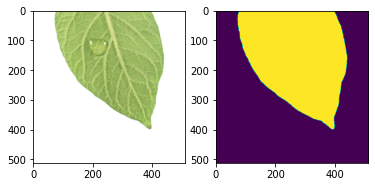

In [7]:
vis_resized = [im[256:, :] for im in vis_padded] + [im[0:512,:] for im in vis_padded]
gt_resized = [im[256:, :] for im in gt_padded] + [im[0:512,:] for im in gt_padded]

plt.subplot(1,2,1)
plt.imshow(vis_resized[23])
plt.subplot(1,2,2)
plt.imshow(gt_resized[23])
plt.show()

In [8]:
vis_resized = np.array(vis_resized)
gt_resized = np.array(gt_resized)

x_train, x_val, y_train, y_val = train_test_split(vis_resized, gt_resized, test_size = .2, random_state = 42)
print("x and y shape for training: ", x_train.shape, y_train.shape, '\n',
      "x and y for validation: ", x_val.shape, y_val.shape)

x and y shape for training:  (105, 512, 512, 3) (105, 512, 512) 
 x and y for validation:  (27, 512, 512, 3) (27, 512, 512)


The model needs annotations with dummy labels:

In [9]:
train_masks_cat = to_categorical(y_train, num_classes = 3)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))

val_masks_cat = to_categorical(y_val, num_classes = 3)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 3))

print("Before:", y_train.shape, y_val.shape, '\n',
      "After:", y_train_cat.shape, y_val_cat.shape)

Before: (105, 512, 512) (27, 512, 512) 
 After: (105, 512, 512, 3) (27, 512, 512, 3)


In [10]:
def jaccard_coef(y_true, y_pred):
    """Computes Jaccard score between ground truth and segmented image

    Args:
        y_true (ndarray): ground truth
        y_pred (ndarray): segmented image

    Returns:
        float: Jaccard score
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

The jaccard_coef() function is taken from: <br>
https://github.com/bnsreenu/python_for_microscopists/blob/2c2b120fec17d8686572719916920bc05e3288f8/207-simple_unet_model_with_jacard.py

In [11]:
learning_rate = .0001
optim = tf.keras.optimizers.Adam(learning_rate) 
metrics = [jaccard_coef]                                 
loss = 'categorical_crossentropy'    

#####################     EXECUTE ONLY IF YOU DON'T WANT TO IMPORT THE MODEL     #####################

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------

In [12]:
model = sm.Unet(
    backbone_name = 'resnet34',
    encoder_weights='imagenet', 
    #encoder_freeze = True,
    input_shape = (512,512,3), 
    classes=3, 
    activation = 'softmax')

85532672/85521592 [==============================] - 1s 0us/step


In [13]:
model.compile(optimizer = optim, loss = loss, metrics = metrics)

In [14]:
history=model.fit(x_train,
          y_train_cat,
          batch_size = 8, 
          epochs=100,
          verbose=1,
          validation_data=(x_val, y_val_cat))

Epoch 1/100
14/14 [==============================] - 31s 941ms/step - loss: 0.8469 - jaccard_coef: 0.3243 - val_loss: 0.9124 - val_jaccard_coef: 0.2811
Epoch 2/100
14/14 [==============================] - 7s 498ms/step - loss: 0.4877 - jaccard_coef: 0.4770 - val_loss: 0.8645 - val_jaccard_coef: 0.3501
Epoch 3/100
14/14 [==============================] - 7s 504ms/step - loss: 0.3463 - jaccard_coef: 0.5755 - val_loss: 0.8738 - val_jaccard_coef: 0.3951
Epoch 4/100
14/14 [==============================] - 7s 491ms/step - loss: 0.2804 - jaccard_coef: 0.6311 - val_loss: 0.7007 - val_jaccard_coef: 0.4521
Epoch 5/100
14/14 [==============================] - 7s 497ms/step - loss: 0.2293 - jaccard_coef: 0.6771 - val_loss: 0.5807 - val_jaccard_coef: 0.4941
Epoch 6/100
14/14 [==============================] - 7s 495ms/step - loss: 0.2054 - jaccard_coef: 0.7084 - val_loss: 0.4783 - val_jaccard_coef: 0.5224
Epoch 7/100
14/14 [==============================] - 7s 493ms/step - loss: 0.1815 - jaccard_c

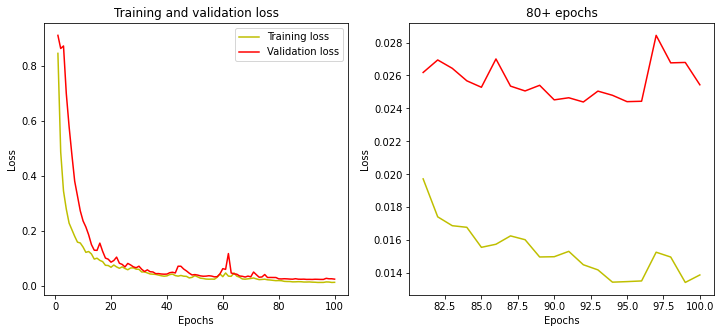

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(epochs, loss, 'y', label='Training loss')
ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
ax[0].title.set_text('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs[80:], loss[80:], 'y', label='Training loss')
ax[1].plot(epochs[80:], val_loss[80:], 'r', label='Validation loss')
ax[1].title.set_text('80+ epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
#ax[1].set_ylim([0, .05])
plt.show()

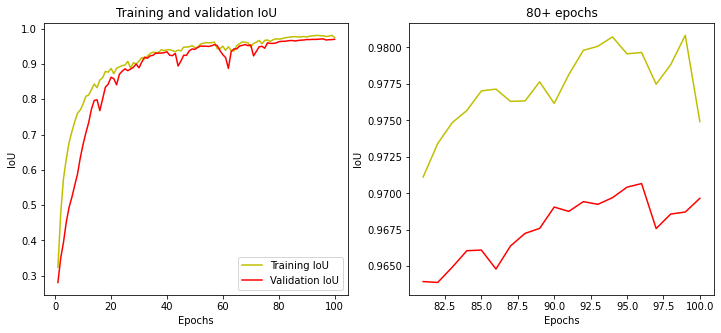

In [16]:
acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(epochs, acc, 'y', label='Training IoU')
ax[0].plot(epochs, val_acc, 'r', label='Validation IoU')
ax[0].title.set_text('Training and validation IoU')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('IoU')
ax[0].legend()

ax[1].plot(epochs[80:], acc[80:], 'y', label='Training IoU')
ax[1].plot(epochs[80:], val_acc[80:], 'r', label='Validation IoU')
ax[1].title.set_text('80+ epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('IoU')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Train_leaves/Saved_models/unet3.hdf5')

#####################################################################################

To load the model we just built:

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Train_leaves/Saved_models/unet3.hdf5',
                                  custom_objects = {"categorical_crossentropy":loss, "jaccard_coef":jaccard_coef})

Testing on 1 image:

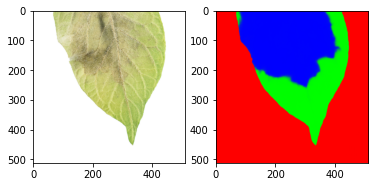

In [ ]:
imtest = x_val[18]
imtest_expanded = np.expand_dims(imtest, 0)
restest = model.predict(imtest_expanded)   

plt.subplot(121)
plt.imshow(imtest)
plt.subplot(122)    
plt.imshow(np.squeeze(restest))
plt.show()

In [ ]:
# PREDICTIONS ON TEST DATASET
files_test_vis = ski.imread_collection("/content/drive/MyDrive/Train_leaves/Test_dataset/Vis/*").files
files_test_gt = ski.imread_collection("/content/drive/MyDrive/Train_leaves/Test_dataset/GT/*").files
vis_test = [ski.imread(image_path) for image_path in files_test_vis]
gt_test = [ski.imread(image_path) for image_path in files_test_gt]
gt_test = np.array(gt_test)  
for im in gt_test:       
    im[im == 0] = 0
    im[im == 100] = 1
    im[im == 200] = 2

vis_test_padded = [resize_padding(im, True, 768, 512) for im in vis_test]    
vis_test_padded = np.array(vis_test_padded)

vis_test_resized = np.array([im[256:, :] for im in vis_test_padded] + [im[0:512,:] for im in vis_test_padded])

<ipython-input-27-845674df1059>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gt_test = np.array(gt_test)    #we don't add padding for our masks, as we will get back to the original size before comparing predictions with them


In [ ]:
imtest_pred = [np.squeeze(model.predict(np.expand_dims(im, 0))) for im in vis_test_resized]

In [ ]:
def merge_vertical(top_img, bot_img, overlap):
    """Merges 2 patches of 512*512 pixels each

    Args:
        top_img (ndarray): patch corresponding to the top of the image
        bot_img (ndarray): patch corresponding to the bottom of the image
        overlap (int): number of pixels on which the 2 patches overlap

    Returns:
        full_img (ndarray): image resulting from the coupling of the 2 patches
    """
    top = top_img[0:top_img.shape[0] - overlap, :]
    bot = bot_img[bot_img.shape[0] - top.shape[0]:, :]
    mid_top = top_img[top_img.shape[0] - overlap:top_img.shape[0], :]       
    mid_bot = bot_img[0:overlap, :]

    full_img = cv2.vconcat([top, mid_top])
    full_img = cv2.vconcat([full_img, bot])

    for i in range(1, 10):
      full_img[512 - (i-1),:] = i*.1*top_img[512 - i,:] + (1 - i*.1)*bot_img[overlap - (i-1),:]
    
    return full_img

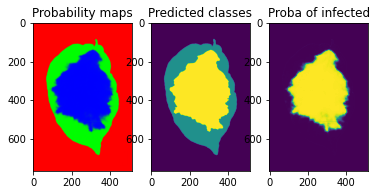

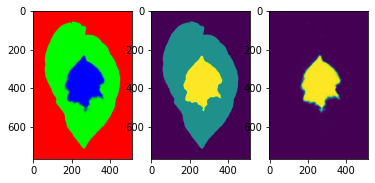

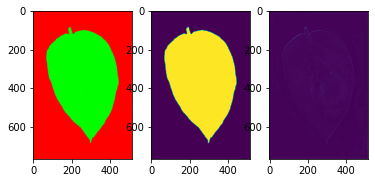

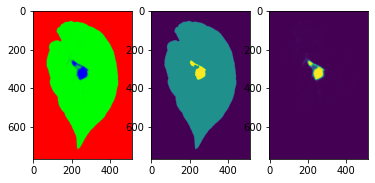

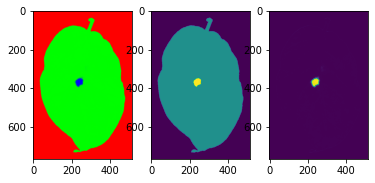

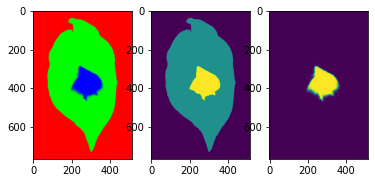

In [ ]:
test_results = []

for i in range(0, len(vis_test_resized)//2):
  overlap = abs(vis_test_padded[i].shape[0] - 2*512)
  prediction = merge_vertical(imtest_pred[i + 6], imtest_pred[i], overlap)
  predicted_classes = np.argmax(prediction, axis = 2)
  test_results.append(predicted_classes)
  proba_infected = prediction[:,:,2]

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  if i == 0:
    ax1.set_title('Probability maps')
    ax2.set_title('Predicted classes')
    ax3.set_title('Proba of infected')
  ax1.imshow(prediction)
  ax2.imshow(predicted_classes)
  ax3.imshow(proba_infected)
  plt.show()

In [ ]:
test_results_cropped = []

for i, im_to_crop in enumerate(test_results):    
  target_height = gt_test[i].shape[0]
  target_width = gt_test[i].shape[1]
  test_results_cropped.append(crop(im_to_crop, target_height, target_width))

Lastly, we compute the metrics to evaluate the performance of our model on the test dataset :

In [ ]:
jac = []
b_acc = []

for i, prediction in enumerate(test_results_cropped):
  jac.append(jaccard_score(pd.DataFrame(prediction.flatten()), pd.DataFrame(gt_test[i].flatten()), average = 'macro'))
  b_acc.append(balanced_accuracy_score(pd.DataFrame(prediction.flatten()), pd.DataFrame(gt_test[i].flatten())))

print(jac)
print(b_acc)
print("\n")
print("################################################################")
print("Mean IoU obtained on test dataset : ", round(np.mean(jac), 5))    
print("Mean balanced accuracy obtained on test dataset : ", round(np.mean(b_acc), 5))
print("################################################################")

[0.8130616362682815, 0.8383635548072887, 0.9976740303277665, 0.7941002452389595, 0.868007928956743, 0.8639194754978435]
[0.8875120366018554, 0.9423831320310082, 0.9988988429572512, 0.8024066086491839, 0.9974286473730309, 0.8803282144305032]


################################################################
Mean IoU obtained on test dataset :  0.86252
Mean balanced accuracy obtained on test dataset :  0.91816
################################################################


### Using the model with specific images I want to test : 

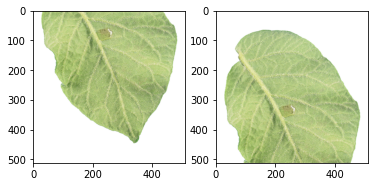

(<matplotlib.image.AxesImage at 0x7f15807c4160>, None)

In [ ]:
not_annotated_set = ski.imread_collection("/content/drive/MyDrive/Train_leaves/Images_a_tester/*").files
leaves = [ski.imread(image_path) for image_path in not_annotated_set]

leaves_padded = [resize_padding(im, True, 768, 512) for im in leaves]    
leaves_padded = np.array(leaves_padded)
leaves_resized = np.array([im[256:, :] for im in leaves_padded] + [im[0:512,:] for im in leaves_padded])

plt.subplot(121)
plt.imshow(leaves_resized[0])
plt.subplot(122)
plt.imshow(leaves_resized[len(not_annotated_set)//2 +2]), plt.show()

In [ ]:
leaves_pred = [np.squeeze(model.predict(np.expand_dims(im, 0))) for im in leaves_resized]

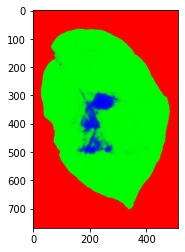

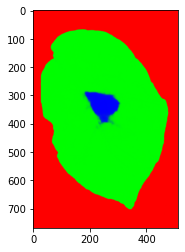

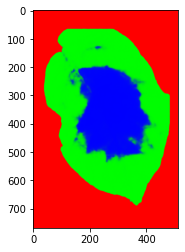

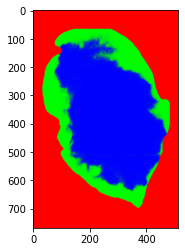

In [ ]:
for i in range(len(leaves_pred)//2):
  overlap = abs(leaves_padded[i].shape[0] - 2*512)
  img = merge_vertical(leaves_pred[i+4], leaves_pred[i], overlap)
  plt.imshow(img)
  plt.show()